# Прогноз оттока клиентов банка 

Из банка ежемесячно стали уходить клиенты. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
Для анализа предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Следует постройте модель с предельно большим значением *F1*-меры.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
# импортируем библиотеки  

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import shuffle

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

In [2]:
# загрузим датасет и рассмотрим первые 5 строк таблицы
try:
    data=pd.read_csv('/datasets/Churn.csv')
except:
    data=pd.read_csv('https://code.s3.yandex.net//datasets/Churn.csv')

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

- Exited — факт ухода клиента

In [3]:
#раcсмотрим общую информацию о датасете
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


В столбце Tenure (сколько лет человек является клиентом банка) есть пропуски. Заполним их медианой в зависимости от колличества продуктов используемых клиентом. Сменим формат на int64, т.к. колличество полных лет не может быть дробным числом. 

In [4]:
data['Tenure'].unique()
for value in data['NumOfProducts'].unique():
    median_t = data.loc[data['NumOfProducts']== value, 'Tenure'].median()
    data.loc[(data['Tenure'].isna()) & (data['NumOfProducts']==value), 'Tenure'] = median_t

In [5]:
# изменим формат данных 
data['Tenure'] = data['Tenure'].astype(int)
#проверка
data['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

In [6]:
#удалим столбцы неинформативные для обучения моделей
data = data.drop(['RowNumber','CustomerId', 'Surname'], axis=1)

In [7]:
#Проверим на наличие явных дубликатов
data.duplicated().sum()

0

После обработки таблица содержит 10 000 строк и 11 столбцов. Пропуски с стотлбце Tenure были заполненны медианой в зависимости от колличества продуктов используемых клиентом. Изменен формат данных в стобце Tenure, т.к. колличество полных лет не может быть дробным числом. Были удалены столбцы RowNumber, CustomerId, Surname, т.к. они не несли информации для обучения моделей.

### Подготовим данные к ML

**Разобьем данные на выборки**

In [9]:
# извлекаем матрицу признаков
features = data.drop(['Exited'], axis=1) 
# извлекаем целевой признак
target = data['Exited']

Так как спрятанной тестовой выборки у нас нет. Данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Разобьем исходные данные в соотношении 3:1:1.(60%:20%:20%)


In [10]:
# отделим 40% данных для тестовой и валидационной выборок
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.40, random_state=321,stratify=target)

# отделим 20% данных для валидационной выборки
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.50, random_state=321, stratify=target_test) 

print('features_train','',features_train.shape[0])
print('features_valid','',features_valid.shape[0])
print('features_test','',features_test.shape[0])

features_train  6000
features_valid  2000
features_test  2000


Преобразуем категориальные признаки

In [13]:
#Преобразуем категориальные признаки в численные при помощи техники прямого кодирования
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)

Стандартизируем численные признаки.

In [14]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [15]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2157,0.971981,0.475727,-0.717643,-1.237462,0.819551,1,1,1.533256,0,0,0
5977,0.557035,0.097014,0.366137,0.296686,-0.904609,0,1,1.376348,0,0,0
2853,-1.694045,1.327831,-0.356383,1.972008,-0.904609,1,1,-1.323672,0,0,1
9105,0.079848,-0.755091,0.004877,0.371088,-0.904609,0,1,-0.879864,0,0,1
9154,-0.718923,-1.133803,0.004877,0.406061,0.819551,1,0,1.631466,0,0,0


Подготовленны три маштабированные выборки для дальнейшего обучения моделей.

## Исследование задачи

Исследуем баланс классов
 

In [16]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

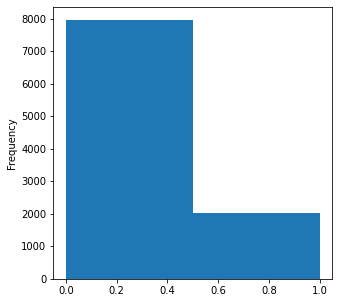

In [17]:
# Построим диаграмму баланса классов
target.plot(kind ='hist', bins=2, figsize=(5,5));

Соотношение классов около 1:4. Можно сдлеать вывод о том, что данные не сбалансированны.

**Продожлим исследование без учета дисбаланса классов**

Подберем лучшие параметры для модели Дерево решений

In [18]:
best_F = 0
best_depth = 0
best_sample = 0 

for depth in range(1,10):
    for sample in range(2,5):
        model_tree = DecisionTreeClassifier(max_depth=depth, random_state=321,min_samples_split =sample)
        model_tree.fit(features_train, target_train)
        predicted_valid_tree = model_tree.predict(features_valid)
        f1 = f1_score(target_valid,predicted_valid_tree)
        if f1 > best_F:
            best_F = f1
            best_depth = depth
            best_sample = sample
print("Глубина дерева:", best_depth, "\nОбъектов в узле:",best_sample, "\nF1:", best_F)

Глубина дерева: 7 
Объектов в узле: 2 
F1: 0.5774436090225564


Подберем лучшие параметры для модели Случайный лес

In [19]:
best_F = 0
best_depth = 0
best_est = 0
best_sample = 0

for depth in range(2,30):
    for est in range(10, 50, 10): 
        for sample in range(2,5):
            model_forest = RandomForestClassifier( max_depth=depth, n_estimators=est, 
                                           min_samples_leaf=sample, random_state=321)
            model_forest.fit(features_train, target_train)
            predicted_valid_forest = model_forest.predict(features_valid)
            #accuracy = model_forest.score(features_valid, target_valid)
            f1 = f1_score(target_valid,predicted_valid_forest)
            if f1 > best_F:
                best_F = f1
                best_depth = depth
                best_est = est
                best_sample = sample
                
print("Глубина дерева:", best_depth, "\nКоличество деревьев:",best_est, "\nОбъектов в узле:", best_sample)
print("F1",best_F)

Глубина дерева: 15 
Количество деревьев: 40 
Объектов в узле: 3
F1 0.6208955223880598


Обучим модели без учета дисбаланса классов и создадим константную модель: любому объекту она прогнозирует класс «0».

In [20]:
#Дерево решений
model_tree = DecisionTreeClassifier(max_depth=7, random_state=321,min_samples_split =2)
model_tree.fit(features_train, target_train)
#Случайный лес
model_forest = RandomForestClassifier(max_depth=15, n_estimators=40, min_samples_leaf=3, random_state=321)
model_forest.fit(features_train, target_train)
#Логистическая регрессия
model_logist = LogisticRegression(random_state=321, solver='lbfgs')
model_logist.fit(features_train, target_train)
#Констатная модель
target_pred_constant = pd.Series(0, index=target.index)

Расчитаем их показатели Accuracy, Precision, Recall и F1

In [21]:
#показатели для девера решений
predicted_valid_tree = model_tree.predict(features_valid)
accuracy_tree = model_tree.score(features_valid, target_valid)
precision_tree = precision_score(target_valid, predicted_valid_tree)
recall_tree = recall_score(target_valid, predicted_valid_tree)
f1_tree = f1_score(target_valid,predicted_valid_tree)

#показатели для случайного леса
predicted_valid_forest = model_forest.predict(features_valid)
accuracy_forest = model_forest.score(features_valid, target_valid) 
precision_forest = precision_score(target_valid, predicted_valid_forest)
recall_forest = recall_score(target_valid, predicted_valid_forest)
f1_forest = f1_score(target_valid,predicted_valid_forest)

#показатели для логистической регрессии
predicted_valid_logist = model_logist.predict(features_valid)
accuracy_logist= model_logist.score(features_valid, target_valid)
precision_logist = precision_score(target_valid, predicted_valid_logist)
recall_logist = recall_score(target_valid, predicted_valid_logist)
f1_logist = f1_score(target_valid,predicted_valid_logist)

#показатели для константной модели
accuracy_constant= accuracy_score(target, target_pred_constant)


print('Показетели для дерева решений:','\nAccuracy:',accuracy_tree,'\nPrecision:',precision_tree,
      '\nRecall:',recall_tree,'\nF1:',f1_tree,'\n','__'*10)
print('\nПоказетели для Случайного леса:','\nAccuracy:',accuracy_forest,'\nPrecision:',precision_forest,
      '\nRecall:',recall_forest,'\nF1:',f1_forest,'\n','__'*10)
print('\nПоказетели для Логистической регрессии:','\nAccuracy:',accuracy_logist,'\nPrecision:',precision_logist,
      '\nRecall:',recall_logist,'\nF1:',f1_logist,'\n','__'*10)
print('\nПоказетели для Константной модели:','\nAccuracy:',accuracy_constant)

Показетели для дерева решений: 
Accuracy: 0.8595 
Precision: 0.7441860465116279 
Recall: 0.47174447174447176 
F1: 0.5774436090225564 
 ____________________

Показетели для Случайного леса: 
Accuracy: 0.873 
Precision: 0.7908745247148289 
Recall: 0.5110565110565111 
F1: 0.6208955223880598 
 ____________________

Показетели для Логистической регрессии: 
Accuracy: 0.808 
Precision: 0.5864661654135338 
Recall: 0.19164619164619165 
F1: 0.2888888888888889 
 ____________________

Показетели для Константной модели: 
Accuracy: 0.7963


Все модели выдали достаточно высокий показатель Accuracy (доля правильных ответов), но он также высок и у константной модели. Это может быть вызванно дисбалансом данных. У можелей Дерово решений и Логистическая регрессия - низкие показатели F1.Модель Случайного леса выдает высокие результаты даже до устранения дисбаланса классов.

In [22]:
# Матрицы ошибок
predicted_valid_tree = model_tree.predict(features_valid)
predicted_valid_forest = model_forest.predict(features_valid)
predicted_valid_logist = model_logist.predict(features_valid)


print('Матрица ошибок дерева решений:\n',confusion_matrix(target_valid,predicted_valid_tree))
print('\nМатрица ошибок модели случайного леса:\n',confusion_matrix(target_valid,predicted_valid_forest))
print('\nМатрица ошибок логистической регрессии:\n',confusion_matrix(target_valid,predicted_valid_logist))

Матрица ошибок дерева решений:
 [[1527   66]
 [ 215  192]]

Матрица ошибок модели случайного леса:
 [[1538   55]
 [ 199  208]]

Матрица ошибок логистической регрессии:
 [[1538   55]
 [ 329   78]]


Модель дерева решений чаще других склонна выдавать FP (ложно позитивные) ответы. Логистическая регрессия чаще выдает FN (ложно негативные) ответы. Несмотря на наличие ошибок (вызванных дисбалансом данных) на данном этапе лучше всего себя показывает модель случайного леса.

Проведем построение ROC-кривых для моделей. Расчитаем показатель AUC-ROC.

AUC-ROC Дерево решений: 0.8300650419294486
AUC-ROC Случайный лес: 0.8600966143339024
AUC-ROC Логистическая регрессия: 0.7781818798767952


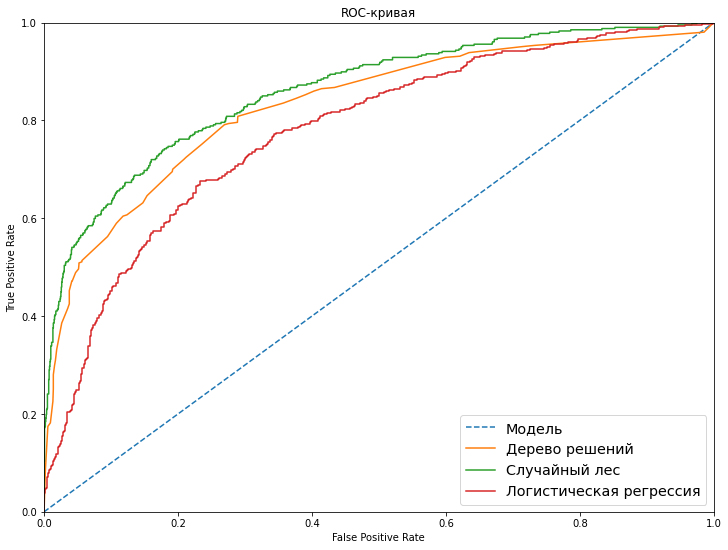

In [23]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Модель')


probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC Дерево решений:',auc_roc)
plt.plot(fpr, tpr, label='Дерево решений')

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC Случайный лес:',auc_roc)
plt.plot(fpr, tpr, label='Случайный лес')

probabilities_valid = model_logist.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC Логистическая регрессия:',auc_roc)
plt.plot(fpr, tpr, label='Логистическая регрессия')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

На данном этапе был выявлен дисбаланс данных в соотношении классов 1:4.
Наибольшие показатели F1 и AUC-ROC полученны у модели Случайного леса.

## Борьба с дисбалансом

**Увеличение выборки**

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=321)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train,4)

print(target_upsampled.value_counts())

1    4888
0    4778
Name: Exited, dtype: int64


In [25]:
# подберем лучшие параметры для дерева решений при upsampled
best_F = 0
best_depth = 0
best_sample = 0 

for depth in range(1,10):
    for sample in range(2,5):
        model_tree = DecisionTreeClassifier(max_depth=depth, random_state=321,min_samples_split =sample)
        model_tree.fit(features_upsampled, target_upsampled)
        predicted_valid_tree = model_tree.predict(features_valid)
        f1 = f1_score(target_valid,predicted_valid_tree)
        if f1 > best_F:
            best_F = f1
            best_depth = depth
            best_sample = sample
print("Глубина дерева:", best_depth, "\nОбъектов в узле:",best_sample, "\nF1:", best_F)

Глубина дерева: 8 
Объектов в узле: 2 
F1: 0.5697786333012511


In [26]:
# подберем лучшие параметры для случайного леса при upsampled

best_F = 0
best_depth = 0

for depth in range(2,30):
    for est in range(10, 50, 10): 
        for sample in range(2,5):
            model_forest = RandomForestClassifier( max_depth=depth, n_estimators=est, 
                                           min_samples_leaf=sample, random_state=321)
            model_forest.fit(features_upsampled, target_upsampled)
            predicted_valid_forest = model_forest.predict(features_valid)
            f1 = f1_score(target_valid,predicted_valid_forest)
            if f1 > best_F:
                best_F = f1
                best_depth = depth
                best_est = est
                best_sample = sample
                
print("Глубина дерева:", best_depth, "\nКоличество деревьев:",best_est, "\nОбъектов в узле:", best_sample)
print("F1",best_F)

Глубина дерева: 12 
Количество деревьев: 30 
Объектов в узле: 2
F1 0.6415525114155252


In [27]:
#показатели для девера решений
model_tree = DecisionTreeClassifier(max_depth=8, random_state=321,min_samples_split =2)
model_tree.fit(features_upsampled, target_upsampled)
predicted_valid_tree = model_tree.predict(features_valid)
accuracy_tree = model_tree.score(features_valid, target_valid)
precision_tree = precision_score(target_valid, predicted_valid_tree)
recall_tree = recall_score(target_valid, predicted_valid_tree)
f1_tree = f1_score(target_valid,predicted_valid_tree)

#показатели для случайного леса
model_forest = RandomForestClassifier(max_depth=12, n_estimators=30,min_samples_leaf=2, random_state=321)
model_forest.fit(features_upsampled, target_upsampled)
predicted_valid_forest = model_forest.predict(features_valid)
accuracy_forest = model_forest.score(features_valid, target_valid) 
precision_forest = precision_score(target_valid, predicted_valid_forest)
recall_forest = recall_score(target_valid, predicted_valid_forest)
f1_forest = f1_score(target_valid,predicted_valid_forest)

#показатели для логистической регрессии
model_logist.fit(features_upsampled, target_upsampled)
predicted_valid_logist = model_logist.predict(features_valid)
accuracy_logist= model_logist.score(features_valid, target_valid)
precision_logist = precision_score(target_valid, predicted_valid_logist)
recall_logist = recall_score(target_valid, predicted_valid_logist)
f1_logist = f1_score(target_valid,predicted_valid_logist)


print('Показетели для дерева решений:','\nAccuracy:',accuracy_tree,'\nPrecision:',precision_tree,
      '\nRecall:',recall_tree,'\nF1:',f1_tree,'\n','__'*10)
print('\nПоказетели для Случайного леса:','\nAccuracy:',accuracy_forest,'\nPrecision:',precision_forest,
      '\nRecall:',recall_forest,'\nF1:',f1_forest,'\n','__'*10)
print('\nПоказетели для Логистической регрессии:','\nAccuracy:',accuracy_logist,'\nPrecision:',precision_logist,
      '\nRecall:',recall_logist,'\nF1:',f1_logist,'\n','__'*10)

Показетели для дерева решений: 
Accuracy: 0.7765 
Precision: 0.46835443037974683 
Recall: 0.7272727272727273 
F1: 0.5697786333012511 
 ____________________

Показетели для Случайного леса: 
Accuracy: 0.843 
Precision: 0.5991471215351812 
Recall: 0.6904176904176904 
F1: 0.6415525114155252 
 ____________________

Показетели для Логистической регрессии: 
Accuracy: 0.7185 
Precision: 0.39572192513368987 
Recall: 0.7272727272727273 
F1: 0.5125541125541125 
 ____________________


При применении метода upsampled(увеличения выборки) для всех моделей снизился показатель точности (Accuracy), но вырос показатель F1. Наибольшую точность показывает модель Случайного леса.

**Уменьшение выборки**

In [28]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=321)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=321)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=321)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(target_downsampled.value_counts())

1    1222
0    1194
Name: Exited, dtype: int64


In [29]:
# подберем лучшие параметры для дерева решений при downsampled
best_F = 0
best_depth = 0
best_sample = 0 

for depth in range(1,10):
    for sample in range(2,5):
        model_tree = DecisionTreeClassifier(max_depth=depth, random_state=321,min_samples_split =sample)
        model_tree.fit(features_downsampled, target_downsampled)
        predicted_valid_tree = model_tree.predict(features_valid)
        f1 = f1_score(target_valid,predicted_valid_tree)
        if f1 > best_F:
            best_F = f1
            best_depth = depth
            best_sample = sample
print("Глубина дерева:", best_depth, "\nОбъектов в узле:",best_sample, "\nF1:", best_F)

Глубина дерева: 7 
Объектов в узле: 2 
F1: 0.5773584905660377


In [30]:
# подберем лучшие параметры для случайного леса при downsampled
best_F = 0
best_depth = 0

for depth in range(2,30):
    for est in range(10, 50, 10): 
        for sample in range(2,5):
            model_forest = RandomForestClassifier( max_depth=depth, n_estimators=est, 
                                           min_samples_leaf=sample, random_state=321)
            model_forest.fit(features_downsampled, target_downsampled)
            predicted_valid_forest = model_forest.predict(features_valid)
            f1 = f1_score(target_valid,predicted_valid_forest)
            if f1 > best_F:
                best_F = f1
                best_depth = depth
                best_est = est
                best_sample = sample
                
print("Глубина дерева:", best_depth, "\nКоличество деревьев:",best_est, "\nОбъектов в узле:", best_sample)
print("F1",best_F)

Глубина дерева: 9 
Количество деревьев: 20 
Объектов в узле: 4
F1 0.5981873111782477


In [31]:
#показатели для девера решений
model_tree = DecisionTreeClassifier(max_depth=7, random_state=321,min_samples_split =2)
model_tree.fit(features_downsampled, target_downsampled)
predicted_valid_tree = model_tree.predict(features_valid)
accuracy_tree = model_tree.score(features_valid, target_valid)
precision_tree = precision_score(target_valid, predicted_valid_tree)
recall_tree = recall_score(target_valid, predicted_valid_tree)
f1_tree = f1_score(target_valid,predicted_valid_tree)

#показатели для случайного леса
model_forest = RandomForestClassifier(max_depth=9, n_estimators=20,min_samples_leaf=4, random_state=321)
model_forest.fit(features_downsampled, target_downsampled)
predicted_valid_forest = model_forest.predict(features_valid)
accuracy_forest = model_forest.score(features_valid, target_valid) 
precision_forest = precision_score(target_valid, predicted_valid_forest)
recall_forest = recall_score(target_valid, predicted_valid_forest)
f1_forest = f1_score(target_valid,predicted_valid_forest)

#показатели для логической регрессии
model_logist.fit(features_downsampled, target_downsampled)
predicted_valid_logist = model_logist.predict(features_valid)
accuracy_logist= model_logist.score(features_valid, target_valid)
precision_logist = precision_score(target_valid, predicted_valid_logist)
recall_logist = recall_score(target_valid, predicted_valid_logist)
f1_logist = f1_score(target_valid,predicted_valid_logist)


print('Показетели для дерева решений:','\nAccuracy:',accuracy_tree,'\nPrecision:',precision_tree,
      '\nRecall:',recall_tree,'\nF1:',f1_tree,'\n','__'*10)
print('\nПоказетели для Случайного леса:','\nAccuracy:',accuracy_forest,'\nPrecision:',precision_forest,
      '\nRecall:',recall_forest,'\nF1:',f1_forest,'\n','__'*10)
print('\nПоказетели для Логической регрессии:','\nAccuracy:',accuracy_logist,'\nPrecision:',precision_logist,
      '\nRecall:',recall_logist,'\nF1:',f1_logist,'\n','__'*10)

Показетели для дерева решений: 
Accuracy: 0.776 
Precision: 0.4686064318529862 
Recall: 0.7518427518427518 
F1: 0.5773584905660377 
 ____________________

Показетели для Случайного леса: 
Accuracy: 0.8005 
Precision: 0.5068259385665529 
Recall: 0.7297297297297297 
F1: 0.5981873111782477 
 ____________________

Показетели для Логической регрессии: 
Accuracy: 0.7175 
Precision: 0.39381720430107525 
Recall: 0.7199017199017199 
F1: 0.5091225021720243 
 ____________________


При применении метода downsampled (уменьшение выборки) показатель F1 ниже, чем при увеличении выборок. 

Для дальнейшей работы будет использованна модель Случайного леса с применением метода увеличения выборки

## Тестирование модели

Для тестирования выбрана модель Случайного леса.

Протестируем модель 

In [32]:
#показатели для случайного леса
top_model_forest = RandomForestClassifier( max_depth=12, n_estimators=30, 
                                           min_samples_leaf=2, random_state=321)
top_model_forest.fit(features_upsampled, target_upsampled)
predicted_forest = top_model_forest.predict(features_test)

accuracy_forest = top_model_forest.score(features_test, target_test) 

precision_forest = precision_score(target_test, predicted_forest)
recall_forest = recall_score(target_test, predicted_forest)
f1_forest = f1_score(target_test,predicted_forest)
print("Accuracy", accuracy_forest)
print('Precision', precision_forest)
print('Recall',recall_forest)
print("F1",f1_forest)

Accuracy 0.8335
Precision 0.5796178343949044
Recall 0.6691176470588235
F1 0.621160409556314


AUC-ROC Случайный лес: 0.8543057695600067
AUC-ROC Случайный лес с балансировкой : 0.854429931520347


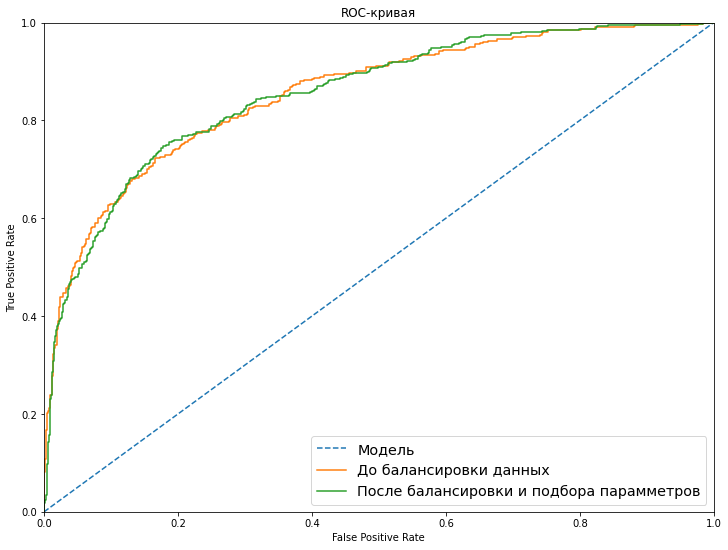

In [33]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Модель')

#до работы с дисбалансом
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC Случайный лес:',auc_roc)
plt.plot(fpr, tpr, label='До балансировки данных')
#после балансировки данных
probabilities_valid = top_model_forest.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('AUC-ROC Случайный лес с балансировкой :',auc_roc)
plt.plot(fpr, tpr, label='После балансировки и подбора парамметров')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Площадь AUC-ROC для модели Случайного леса с балансировкой не показала значительных изменений.

Проведем проверку модели на адекватность. Для проверки используем модель DummyClassifier. Для праметра strategy зададим знаечние uniform, т.к. оно генерирует предсказания равномерно случайным образом из списка уникальных классов.

In [34]:
model_d = DummyClassifier(strategy='uniform', random_state=321)
model_d.fit(features_train, target_train)
result_d = model_d.score(features_valid, target_valid)

print('Accuracy DummyClassifier:', result_d)
print("Accuracy модели Случайный лес:", accuracy_forest)

Accuracy DummyClassifier: 0.4905
Accuracy модели Случайный лес: 0.8335


Accuracy модели DummyClassifier значительно ниже, чем у модели Случайного леса. Из чего можно сделать вывод, что выбранная модель адекватна.

**Вывод** 

При первоначальной обработке данных пропуски в стотлбце Tenure были заполненны медианой в зависимости от колличества продуктов используемых клиентом. Изменен формат данных в стобце Tenure. Были удалены столбцы RowNumber, CustomerId, Surname, т.к. они не несли информации для обучения моделей. Категориальные признаки были преобразованны в численные при помощи OHE. После преобразований для работы был использован датасет содержащий 12 столбцев и 1000 строк. Данные были разбиты на три выборки в соотношении 3:1:1.(60%:20%:20%). Численные признаки были стандартизированны.

Был выявлен дисбаланс классов в соотношении 1:4. Обученные на этих данных модели не проходили проверку на адекватность. 
Для устранения дисбаланса быди применены методы upsampling и downsampling.На новых данных все модели показали результат выше, чем на несбалансированной выборке. 

Наибольшие показатели F1 и AUC-ROC полученны у модели Случайного леса при применении метода upsampled(увеличения выборки). 

Лучшие показатели были у модели случайного леса с параметрами (Глубина дерева: 23, Количество деревьев: 40 ,Объектов в узле: 2):

- Accuracy 0.8335
- Precision 0.5796178343949044
- Recall 0.6691176470588235
- F1 0.621160409556314
- AUC-ROC с балансировкой : 0.854429931520347

Финальная модель прошла проверку на адекватность.